In [3]:
import torch
import sys
import numpy as np
import matplotlib.pyplot as plt
#from google.colab import files
#from google.colab import drive

!apt-get install ffmpeg libsm6 libxext6

import os
import cv2

!pip install breizhcrops

import math
import torch
import torch.nn as nn
from torch.nn.modules.batchnorm import BatchNorm1d
import torchvision
import numpy as np
import lightly
import tqdm
import breizhcrops

!git clone https://github.com/ml-jku/hopfield-layers.git 
!git checkout 1497a4d3eaaa0003a8f73484a562329865a61d02

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
     |████████████████████████████████| 427 kB 10.1 MB/s 
  Attempting uninstall: tornado
    Found existing installation: tornado 4.5.3
    Uninstalling tornado-4.5.3:
      Successfully uninstalled tornado-4.5.3
  Attempting uninstall: jupyter-console
    Found existing installation: jupyter-console 6.4.0
    Uninstalling jupyter-console-6.4.0:
      Successfully uninstalled jupyter-console-6.4.0
You should consider upgrading via the '/home/gitpod/.pyenv/versions/3.8.12/bin/python3 -m pip install --upgrade pip' command.
fatal: destination path 'hopfield-layers' already exists and is not an empty directory.
fatal: reference is not a tree: 1497a4d3eaaa0003a8f73484a562329865a61d02


*Hopfield*

In [4]:
%mv hopfield-layers hopfieldlayers
os.chdir('hopfieldlayers')

sys.path.append(os.path.join('hopfieldlayers')) 
from hflayers import Hopfield, HopfieldPooling, HopfieldLayer

%cd ..

mv: cannot move 'hopfield-layers' to 'hopfieldlayers/hopfield-layers': File exists
/workspace/WorldCrops/notebooks


In [5]:
#helper functions

def load_simpson_faces(path, start, end):
    imgs = []
    simpson_files = os.listdir(path)
    
    for img in simpson_files[start:end]:
        image = cv2.imread(path+img)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = np.array(image)/255.0
        #image = image - np.mean(image)
        imgs.append(image)
    
    return torch.from_numpy(np.array(imgs)).float()

def get_energy(R, Y, beta):
    lse = -(1.0/beta)*torch.logsumexp(beta*(torch.bmm(R, Y.transpose(1,2))), dim=2) # -lse(beta, Y^T*R)
    lnN = (1.0/beta)*torch.log(torch.tensor(Y.shape[1], dtype=float)) # beta^-1*ln(N)
    RTR = 0.5*torch.bmm(R, R.transpose(1,2)) # R^T*R
    M = 0.5*((torch.max(torch.linalg.norm(Y, dim=2), dim=1))[0]**2.0) # 0.5*M^2  *very large value*
    energy = lse + lnN + RTR + M
    return energy

In [6]:
#get the simpsons images from local google drive
#downloaded from 
#https://www.kaggle.com/kostastokis/simpsons-faces

drive.mount('/content/drive')
imgs = load_simpson_faces('/content/drive/MyDrive/cropped/', 0, 30)

NameError: name 'drive' is not defined

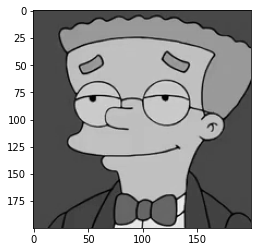

In [ ]:
Y = imgs.clone().reshape(30,-1).unsqueeze(0) # stored patterns 
plt.imshow(Y.squeeze(0)[0].reshape(200,200), cmap='gray')

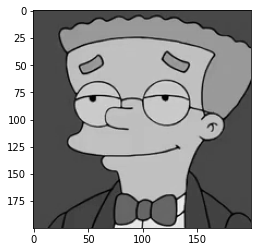

In [ ]:
lowres = cv2.resize(np.array(Y.squeeze(0)[0].reshape(200,200)),(50,50), interpolation = cv2.INTER_AREA)
lowres = cv2.resize(lowres,(200,200), interpolation = cv2.INTER_AREA)
lowres = np.array(Y.squeeze(0)[0].reshape(200,200))
plt.imshow(lowres,  cmap='gray')

In [ ]:
copy = imgs.clone().reshape(30,-1).unsqueeze(0)
R = copy.squeeze(0)[2].reshape(200,200)
#R = torch.from_numpy(lowres)
R += torch.rand(R.shape)*0.45 # inject noise into state pattern
R.clamp_(0, 1)
R = R.reshape(1,-1).unsqueeze(0)

In [ ]:
R = copy.squeeze(0)[4].reshape(200,200)
R.clamp_(0, 1)
R = R.reshape(1,-1).unsqueeze(0)
Y.shape

torch.Size([1, 8, 40000])

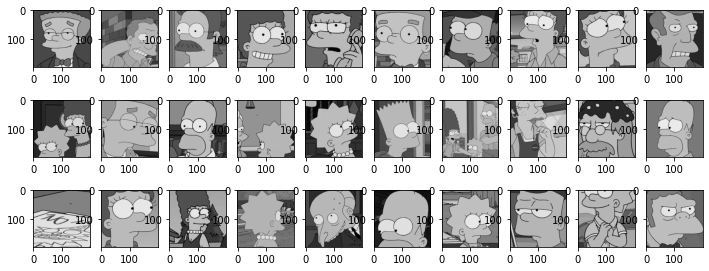

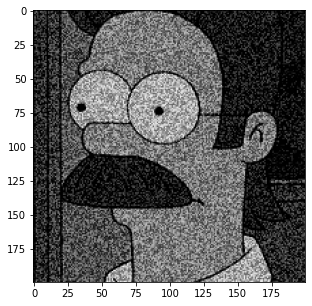

In [ ]:
plt.figure(figsize=(6*2,4*2))
for i in range(Y.shape[1]):
    plt.subplot(5,10,i+1)
    plt.imshow(Y.squeeze(0)[i].reshape(200,200), cmap='gray')
    
plt.figure(figsize=(5,5))
plt.imshow(R.squeeze(0).squeeze(0).reshape(200,200), cmap='gray')

In [ ]:
Y.shape

In [ ]:
hopfield = Hopfield(
    scaling=.2,
    pattern_size =80,
    input_bias=True,
    
    # do not project layer input
    state_pattern_as_static=True,
    stored_pattern_as_static=True,
    pattern_projection_as_static=True,

    # do not pre-process layer input
    normalize_stored_pattern=False,
    normalize_stored_pattern_affine=False,
    normalize_state_pattern=False,
    normalize_state_pattern_affine=False,
    normalize_pattern_projection=False,
    normalize_pattern_projection_affine=False,

    # do not post-process layer output
    disable_out_projection=True)


#R Noisy State Pattern, Z Retrieved Pattern
Z = hopfield((Y, R, Y))

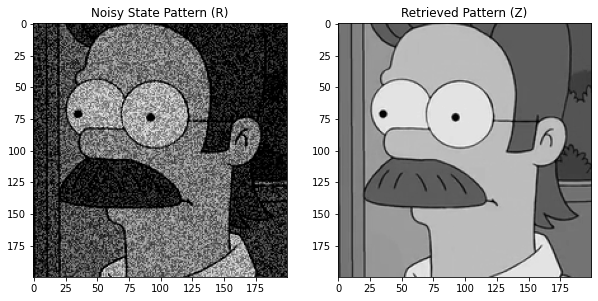

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('Noisy State Pattern (R)')
plt.imshow(R.squeeze(0).squeeze(0).reshape(200,200), cmap='gray')
plt.subplot(1,2,2)
plt.title('Retrieved Pattern (Z)')
plt.imshow(Z.squeeze(0).squeeze(0).reshape(200,200), cmap='gray')

In [ ]:
#energy of noisy image
get_energy(R, Y, hopfield.scaling)

tensor([[[2338.6108]]])

In [ ]:
#energy of retrieved image
get_energy(Z, Y, hopfield.scaling)

tensor([[[804.8467]]])

*Embeddings*


In [ ]:
#************Parameter********************
##########################################

num_workers = 8
batch_size = 128
seed = 1
epochs = 50
input_size = 256

# dimension of the embeddings
num_ftrs = 512
# dimension of the output of the prediction and projection heads
out_dim = proj_hidden_dim = 512
# the prediction head uses a bottleneck architecture
pred_hidden_dim = 128

# seed torch and numpy
torch.manual_seed(0)
np.random.seed(0)

# set the path to the dataset
path_to_data = '/datasets/sentinel-2-italy-v1/'

In [ ]:
#************Augmentation and data********
##########################################

# define the augmentations for self-supervised learning
collate_fn = lightly.data.ImageCollateFunction(
    input_size=input_size,
    # require invariance to flips and rotations
    hf_prob=0.5,
    vf_prob=0.5,
    rr_prob=0.5,
    # satellite images are all taken from the same height
    # so we use only slight random cropping
    min_scale=0.5,
    # use a weak color jitter for invariance w.r.t small color changes
    cj_prob=0.2,
    cj_bright=0.1,
    cj_contrast=0.1,
    cj_hue=0.1,
    cj_sat=0.1,
)

# create a lightly dataset for training, since the augmentations are handled
# by the collate function, there is no need to apply additional ones here
dataset_train_simsiam = lightly.data.LightlyDataset(
    input_dir=path_to_data
)

# create a dataloader for training
dataloader_train_simsiam = torch.utils.data.DataLoader(
    dataset_train_simsiam,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    drop_last=True,
    num_workers=num_workers
)

# create a torchvision transformation for embedding the dataset after training
# here, we resize the images to match the input size during training and apply
# a normalization of the color channel based on statistics from imagenet
test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((input_size, input_size)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=lightly.data.collate.imagenet_normalize['mean'],
        std=lightly.data.collate.imagenet_normalize['std'],
    )
])



# create a lightly dataset for embedding
dataset_test = lightly.data.LightlyDataset(
    input_dir=path_to_data,
    transform=test_transforms
)



# create a dataloader for embedding
dataloader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

In [ ]:
# we use a pretrained resnet for this tutorial to speed
# up training time but you can also train one from scratch
resnet = torchvision.models.resnet18()
backbone = nn.Sequential(*list(resnet.children())[:-1])

# create the SimSiam model using the backbone from above
model = lightly.models.SimSiam(
    backbone,
    num_ftrs=num_ftrs,
    proj_hidden_dim=proj_hidden_dim,
    pred_hidden_dim=pred_hidden_dim,
    out_dim=out_dim,
)

# replace the 3-layer projection head by a 2-layer projection head
# (similar to how it's done for SimSiam on Cifar10)
model.projection_mlp = lightly.models.modules.heads.ProjectionHead([
    (num_ftrs, proj_hidden_dim, nn.BatchNorm1d(proj_hidden_dim), nn.ReLU()),
    (proj_hidden_dim, out_dim, nn.BatchNorm1d(out_dim), None)
])

In [ ]:
# SimSiam uses a symmetric negative cosine similarity loss
criterion = lightly.loss.SymNegCosineSimilarityLoss()

# scale the learning rate
lr = 0.05 * batch_size / 256
# use SGD with momentum and weight decay
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=lr,
    momentum=0.9,
    weight_decay=5e-4
)


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

avg_loss = 0.
avg_output_std = 0.
for e in range(epochs):

    for (x0, x1), _, _ in dataloader_train_simsiam:

        # move images to the gpu
        x0 = x0.to(device)
        x1 = x1.to(device)

        # run the model on both transforms of the images
        # the output of the simsiam model is a y containing the predictions
        # and projections for each input x
        y0, y1 = model(x0, x1)

        # backpropagation
        loss = criterion(y0, y1)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        # calculate the per-dimension standard deviation of the outputs
        # we can use this later to check whether the embeddings are collapsing
        output, _ = y0
        output = output.detach()
        output = torch.nn.functional.normalize(output, dim=1)

        output_std = torch.std(output, 0)
        output_std = output_std.mean()

        # use moving averages to track the loss and standard deviation
        w = 0.9
        avg_loss = w * avg_loss + (1 - w) * loss.item()
        avg_output_std = w * avg_output_std + (1 - w) * output_std.item()

    # the level of collapse is large if the standard deviation of the l2
    # normalized output is much smaller than 1 / sqrt(dim)
    collapse_level = max(0., 1 - math.sqrt(out_dim) * avg_output_std)
    # print intermediate results
    print(f'[Epoch {e:3d}] '
        f'Loss = {avg_loss:.2f} | '
        f'Collapse Level: {collapse_level:.2f} / 1.00')